## Aprendizado supervisionado - Classificação


Objetivo: prever o segmento do produto dada as descrições do mesmo.

Observações:
- o seguinte notebook precisa ser enxergado como um passo a passo, para uso real, precisa ser melhorado
- dados utilizados não disponíveis

### Cronometra o tempo

In [1]:
import time
t2 = time.time()

# t0 = time.time()
# t1 = time.time()
# print("Esse processo demorou %f segundos" %(t1 - t0))

### Importa bibliotecas/dependências

In [2]:
import sys
import psycopg2
import pandas as pd
import numpy as np

import seaborn as sb
import matplotlib as plt
%matplotlib inline
from wordcloud import WordCloud

from pylab import *
import re
import string
from html import unescape
import unicodedata
from bs4 import BeautifulSoup

import nltk
from nltk.stem.porter import *
from nltk.corpus import stopwords

from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

### Conecta ao banco
Seleciona quais tabelas vão ser utilizadas:

In [3]:
connection = psycopg2.connect(host='', dbname='', user='', password='')
cursor = connection.cursor()
cursor.execute('')
futuro_df = cursor.fetchall()
columns = [c[0] for c in cursor.description]
connection.close()

### Cria o data frame

In [4]:
data_large = pd.DataFrame(futuro_df, columns=columns)

### Cria uma copia do data frame data_large -> df_copy

In [5]:
df_copy = data_large.copy()

### Shape do data frame

In [6]:
df_copy.shape

(100000, 2)

### Visualiza os segmentos presentes 

In [7]:
df_copy["product.segment_nm"].value_counts()[:10]

AUTOMOTIVO                       13648
FASHION - CALÇADOS               10237
INFORMATICA ACESSORIOS            4802
FASHION - ROUPA MASCULINA         4406
MÓVEIS - DECORAÇÃO                4231
ESPORTE & LAZER                   3927
FASHION - BOLSAS E ACESSORIOS     3228
UTILIDADES DOMESTICAS             3199
TELEFONIA                         3197
LIVROS INTERESSE GERAL            2946
Name: product.segment_nm, dtype: int64

### Limpeza dos dados

In [8]:
t0 = time.time()

#### Retira os valores ausentes das descriçoes e segmentos

In [9]:
df_copy = df_copy[df_copy['sku_ds'].notnull()]
df_copy = df_copy[df_copy['product.segment_nm'].notnull()]
df_copy.isnull().sum()

sku_ds                0
product.segment_nm    0
dtype: int64

#### Reseta o index
Para evitar possíveis erros futuros

In [10]:
df_copy = df_copy.reset_index(drop=True)

#### Acrescenta a coluna com os dados limpos no data frame

In [11]:
df_copy['sku_ds_clean'] = (df_copy['sku_ds'])

#### Remove html de strings

In [12]:
def limpa_html(texto):
    soup = BeautifulSoup(unescape(texto), 'lxml')
    text_clean = soup.get_text(" ").strip()
    text_mais_clean = unicodedata.normalize("NFKC", text_clean)
    return text_mais_clean

In [13]:
df_copy["sku_ds_clean"] = df_copy["sku_ds_clean"].apply(limpa_html)

/usr/lib/python3/dist-packages/bs4/__init__.py:198: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  '"%s" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.' % markup)
/usr/lib/python3/dist-packages/bs4/__init__.py:207: UserWarning: "b'https://images-americanas.b2w.io/produtos/01/00/oferta/46554/9/46554981_1GG.jpg'" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client to get the document behind the URL, and feed that document to Beautiful Soup.
  '"%s" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client to get the document behind the URL, and feed that document to Beautiful Soup.' % markup)


#### Remove short words

In [14]:
df_copy['sku_ds_clean'] = df_copy['sku_ds_clean'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
# df_copy.head()

#### Remove pontuaçoes, números e caracteres especiais

In [15]:
df_copy['sku_ds_clean'] = df_copy['sku_ds_clean'].str.replace("[^a-zA-Z#]", " ") 
# df_copy.head()

#### Torna as letras minusculas

In [16]:
df_copy["sku_ds_clean"] = df_copy["sku_ds_clean"].apply(lambda x: x.lower())

#### Remove stopworks

In [17]:
def remove_stopwords(texto):
    texto_no_stop = ""
    token_list = texto.split()
    
    for token in token_list:
        if token not in stopwords.words('portuguese'):
            texto_no_stop += token + " "
    
    return texto_no_stop

In [18]:
df_copy["sku_ds_clean"] = df_copy["sku_ds_clean"].apply(remove_stopwords)

#### Remove acentos

In [19]:
def remove_accentuation(text):
    if text != None:
        return ''.join((c for c in unicodedata.normalize("NFD", text) if unicodedata.category(c) != "Mn"))

In [20]:
df_copy["sku_ds_clean"] = df_copy["sku_ds_clean"].apply(remove_accentuation)

In [21]:
df_copy.head(20)

,sku_ds,product.segment_nm,sku_ds_clean
0,Mesa Helen com tampo de vidro Cimol. Poder reu...,"MÓVEIS - COZINHA, JANTAR, ÁREA DE SERVIÇO E BA...",mesa helen tampo vidro cimol poder reunir fam ...
1,A Capa de celular Palmeira Tropical para Moto ...,TELEFONIA,capa celular palmeira tropical moto concebida ...
2,&lt;p&gt;&lt;b&gt;Teclado para Notebook Hp Pav...,INFORMATICA ACESSORIOS,teclado notebook pavilion dm tx preto abnt tec...
3,• Boné Alpinestars Astar Rubber Logo - Branco&...,FASHION - BOLSAS E ACESSORIOS,bon alpinestars astar rubber logo branco bon a...
4,&lt;p&gt;DESCRIÇÃO: A tintura Color Total Salo...,BELEZA & SAUDE,descri tintura color total salon line colora p...
5,&lt;p&gt;Para complementar o visual do seu car...,AUTOMOTIVO,complementar visual carro trazer seguran voc f...
6,Qualidade dos nossos produtos.&lt;br&gt;A malh...,FASHION - ROUPA INFANTO JUVENIL,qualidade produtos malha utilizamos confec cad...
7,Tela Lcd Para Notebook Gateway Nv5606u,INFORMATICA ACESSORIOS,tela notebook gateway nv u
8,"&lt;p&gt;Corra com muito conforto, leveza e gr...",ESPORTE & LAZER - VESTUÁRIO,corra conforto leveza grande estilo t nis olym...
9,"&lt;p&gt;DETALHES: Altura: 1,30 cm --- Largura...",MÓVEIS - QUARTO,detalhes altura largura profundidade espa ch e...


In [22]:
t1 = time.time()
print("Esse processo demorou %f segundos" %(t1 - t0))

Esse processo demorou 738.844380 segundos


### Analise exploratória dos dados
#### Visualizaçao dos dados com WordCloud

In [23]:
t0 = time.time()

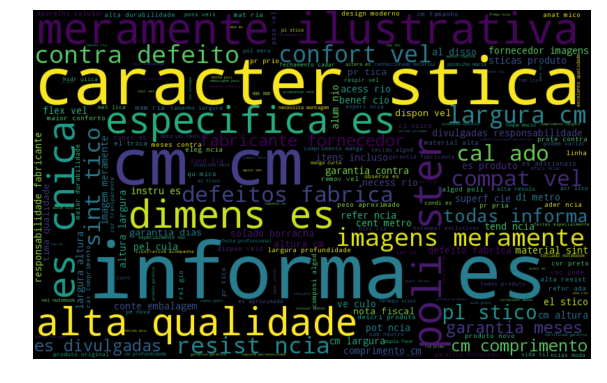

In [24]:
all_words = ' '.join([text for text in df_copy['sku_ds_clean']])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [25]:
t1 = time.time()
print("Esse processo demorou %f segundos" %(t1 - t0))

Esse processo demorou 24.816920 segundos


#### Apos a visualização vi a necessidade de tirar "imagens meramente ilustrativas" pois apareciam com bastante frequência

In [26]:
def tira_pal_inutil(text):
    text = text.replace("imagens meramente ilustrativas", " ")
    text = text.replace("imagem meramente ilustrativa", " ")
    text = text.replace("imagems meramente ilustrativas", " ")
    text = text.replace("imagens meramentes ilustrativas", " ")
    return text    

In [27]:
df_copy["sku_ds_clean"] = df_copy["sku_ds_clean"].apply(tira_pal_inutil)

In [28]:
# matriz de dispersao
# sb.pairplot(df_copy)

In [29]:
# sb.pairplot(df_copy, hue='df_copy['sku_ds_clean']')

### Tokenizacao

In [30]:
t0 = time.time()

#### Text normalization
#### Tokenizing

In [31]:
tokenized_sku_clean = df_copy['sku_ds_clean'].apply(lambda x: x.split(", "))
print(tokenized_sku_clean)

0        [mesa helen tampo vidro cimol poder reunir fam...
1        [capa celular palmeira tropical moto concebida...
2        [teclado notebook pavilion dm tx preto abnt te...
3        [bon alpinestars astar rubber logo branco bon ...
4        [descri tintura color total salon line colora ...
5        [complementar visual carro trazer seguran voc ...
6        [qualidade produtos malha utilizamos confec ca...
7                            [tela notebook gateway nv u ]
8        [corra conforto leveza grande estilo t nis oly...
9        [detalhes altura largura profundidade espa ch ...
10       [branca mortos sete zumbis cl ssico undergroun...
11       [lugar onde existia ilha tamanho ervilha conhe...
12       [quebra cabe pe hatchimals surpresa grow forma...
13       [itens inclusos len ol king santista platinum ...
14       [papete feminino azaleia nome sand lia azaleia...
15       [mochila contact deuter descri mochila aircont...
16       [modernize ilumina ambiente econ mico charmoso.

#### Stemming

In [32]:
stemmer = PorterStemmer() 
tokenized_sku_clean = tokenized_sku_clean.apply(lambda x: [stemmer.stem(i) for i in x])

In [33]:
tokenized_sku_clean.head()

0    [mesa helen tampo vidro cimol poder reunir fam...
1    [capa celular palmeira tropical moto concebida...
2    [teclado notebook pavilion dm tx preto abnt te...
3    [bon alpinestars astar rubber logo branco bon ...
4    [descri tintura color total salon line colora ...
Name: sku_ds_clean, dtype: object

#### Retorna o dado 'tokenizado' e 'stemmizado' para o data frame (como uma frase)

In [34]:
for x in range(len(tokenized_sku_clean)):
    tokenized_sku_clean[x] = ''.join(tokenized_sku_clean[x])
df_copy["sku_ds_clean"] = tokenized_sku_clean

In [35]:
df_copy.head()

,sku_ds,product.segment_nm,sku_ds_clean
0,Mesa Helen com tampo de vidro Cimol. Poder reu...,"MÓVEIS - COZINHA, JANTAR, ÁREA DE SERVIÇO E BA...",mesa helen tampo vidro cimol poder reunir fam ...
1,A Capa de celular Palmeira Tropical para Moto ...,TELEFONIA,capa celular palmeira tropical moto concebida ...
2,&lt;p&gt;&lt;b&gt;Teclado para Notebook Hp Pav...,INFORMATICA ACESSORIOS,teclado notebook pavilion dm tx preto abnt tec...
3,• Boné Alpinestars Astar Rubber Logo - Branco&...,FASHION - BOLSAS E ACESSORIOS,bon alpinestars astar rubber logo branco bon a...
4,&lt;p&gt;DESCRIÇÃO: A tintura Color Total Salo...,BELEZA & SAUDE,descri tintura color total salon line colora p...


In [36]:
t1 = time.time()
print("Esse processo demorou %f segundos" %(t1 - t0))

Esse processo demorou 3.300775 segundos


### Classificação

- Decision tree e Random Forest usando o Grid Search e Cross Validation
- Label Encoder para os segmentos
- TF-IDF para as descricoes

In [37]:
t0 = time.time()

#### Extrai os dados e rótulos (product.segment_nm)

In [38]:
all_inputs = df_copy[['sku_ds_clean']].values
all_labels = df_copy['product.segment_nm'].values

#### Divide os dados em treino e teste

In [39]:
np.random.seed(7)

(training_inputs,
 testing_inputs,
 training_classes,
 testing_classes) = train_test_split(all_inputs,
                                     all_labels,
                                     test_size=0.25,
                                     random_state=7)

#### Label Encoder para 'product.segment_nm'

In [40]:
encoder = LabelEncoder()
training_classes = encoder.fit_transform(training_classes)
testing_classes = encoder.fit_transform(testing_classes)

#### Vetorizacao com TF-IDF

In [41]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.5,
                                   min_df=2,
                                   strip_accents="ascii",
                                   analyzer="word",
                                   ngram_range=(2, 4))

In [42]:
tfidf = tfidf_vectorizer.fit_transform(df_copy["sku_ds_clean"])

#### Shape após vetorização

In [43]:
tfidf.shape

(95273, 1518023)

#### Divisão dos dados vetorizados (distribui quanto será usado no treinamento e no teste)

In [44]:
tres_quartos_tfidf = int((tfidf.shape[0]/4) * 3)
tres_quartos_tfidf

71454

In [45]:
train_tfidf = tfidf[:tres_quartos_tfidf,:] 
test_tfidf =  tfidf[tres_quartos_tfidf:,:] 

#### Shape após divisao dos dados vetorizados

In [46]:
train_tfidf.shape

(71454, 1518023)

In [47]:
t1 = time.time()
print("Esse processo demorou %f segundos" %(t1 - t0))

Esse processo demorou 52.173748 segundos


### Decision Tree

In [48]:
t0 = time.time()

#### Implementa o modelo

In [49]:
#cria o classificador
decision_tree_classifier = DecisionTreeClassifier()

#treina o classificador no conjunto de treinamentos
decision_tree_classifier.fit(train_tfidf, training_classes)

#valida o classificador no conjunto de testes
decision_tree_classifier.score(test_tfidf, testing_classes)

0.06666946555271003

In [50]:
t1 = time.time()
print("Esse processo demorou %f segundos" %(t1 - t0))

Esse processo demorou 13373.420169 segundos


#### Motivacao para usar o Grid Search/Cross Validation:
- overfitting (o modelo está aprendendo a classificar o conjunto de treinamento tão bem que não generaliza e executa bem em dados que não tinha visto antes)
- dependendo de como o conjunto de treino e teste foi amostrado, o modelo pode atingir 80% a 100% de acuracia

- ideia do grid search: explore uma variedade de parâmetros e encontre a combinação de parâmetros com melhor desempenho. Concentre sua pesquisa no melhor intervalo de parâmetros e repita esse processo várias vezes até que os melhores parâmetros sejam descobertos

Obs.: com +100mil dados não consegui plotar o histogram do model_accuracies

In [51]:
#t0 = time.time()

In [52]:
#model_accuracies = []

#for repetition in range(1000):
 #   (training_inputs,
  #   testing_inputs,
   #  training_classes,
    # testing_classes) = train_test_split(tfidf, all_labels, test_size=0.25)
    
    #decision_tree_classifier = DecisionTreeClassifier()
    #decision_tree_classifier.fit(train_tfidf, training_classes)
    #classifier_accuracy = decision_tree_classifier.score(test_tfidf, testing_classes)
    #model_accuracies.append(classifier_accuracy)
    
#plt.hist(model_accuracies)
#;

In [53]:
#t1 = time.time()
#print("Esse processo demorou %f segundos" %(t1 - t0))

#### Validacao cruzada
Validação cruzada k-fold no modelo: divide o conjunto de dados original em k subconjuntos, usa um dos subconjuntos como o conjunto de testes e o restante dos subconjuntos como conjunto de treinamento. Esse processo é repetido k vezes, de modo que cada subconjunto seja usado como o conjunto de testes exatamente uma vez.

A validação cruzada de 10 vezes é a escolha mais comum.

Obs.: cada quadrado é uma entrada em nosso conjunto de dados (grafico)

In [54]:
t0 = time.time()

/home/mion/.local/lib/python3.5/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


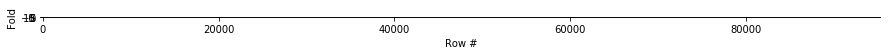

In [55]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

def plot_cv(cv, features, labels):
    masks = []
    for train, test in cv.split(features, labels):
        mask = np.zeros(len(labels), dtype=bool)
        mask[test] = 1
        masks.append(mask)
    
    plt.figure(figsize=(15, 15))
    plt.imshow(masks, interpolation='none', cmap='gray_r')
    plt.ylabel('Fold')
    plt.xlabel('Row #')

plot_cv(StratifiedKFold(n_splits=10), all_inputs, all_labels)

In [56]:
t1 = time.time()
print("Esse processo demorou %f segundos" %(t1 - t0))

Esse processo demorou 0.365986 segundos


#### Executa a validacao cruzada

In [57]:
t0 = time.time()

/home/mion/.local/lib/python3.5/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


Text(0.5, 1.0, 'Average score: 0.6681641308536955')

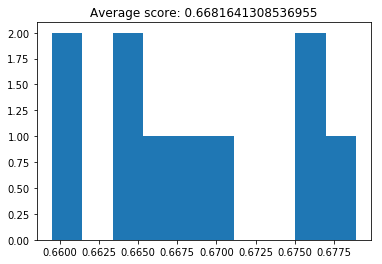

In [58]:
decision_tree_classifier = DecisionTreeClassifier()

# cross_val_score returns a list of the scores, which we can visualize
# to get a reasonable estimate of our classifier's performance
cv_scores = cross_val_score(decision_tree_classifier, 
                           tfidf,
                           all_labels,
                           cv=10)
plt.hist(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))

In [59]:
t1 = time.time()
print("Esse processo demorou %f segundos" %(t1 - t0))

Esse processo demorou 11542.295497 segundos


#### Ajuste de parâmetros
- Agora limito, muito, a profundidade do classificador e vejo que a acurácia cai muito!
- Ou seja, me mostra a importância de usar um metodo sistemático para descobrir os melhores parâmetros para o modelo e conjunto de dados

In [60]:
t0 = time.time()

/home/mion/.local/lib/python3.5/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


''

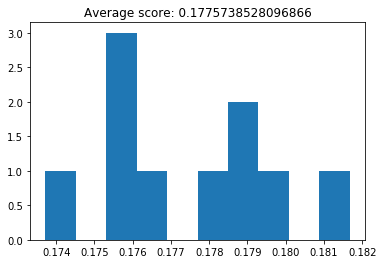

In [61]:
decision_tree_classifier = DecisionTreeClassifier(max_depth=1)

cv_scores = cross_val_score(decision_tree_classifier, tfidf, all_labels, cv=10)

plt.hist(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))
;

In [62]:
t1 = time.time()
print("Esse processo demorou %f segundos" %(t1 - t0))

Esse processo demorou 107.303841 segundos


#### Agora ajusta o classificador decision tree

In [63]:
t0 = time.time()

In [64]:
from sklearn.model_selection import GridSearchCV

decision_tree_classifier = DecisionTreeClassifier()

parameter_grid = {'max_depth': [1, 2, 3, 4, 5],
                  'max_features': [5, 10, 15, 20]}

# {'max_depth': [1, 2, 3, 4, 5],
# 'max_features': [1, 2, 3, 4]

cross_validation = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(decision_tree_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(tfidf, all_labels)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

/home/mion/.local/lib/python3.5/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


Best score: 0.145833541544439
Best parameters: {'max_features': 20, 'max_depth': 5}


In [65]:
t1 = time.time()
print("Esse processo demorou %f segundos" %(t1 - t0))

Esse processo demorou 105.306421 segundos


#### Visualizar em grade para ver como os parâmetros interagem

In [66]:
# t0 = time.time()

In [67]:
#grid_visualization = grid_search.cv_results_['mean_test_score']
#grid_visualization.shape = (1, 40)
#sb.heatmap(grid_visualization, cmap='Blues', annot=True)
#plt.xticks(np.arange(1) + 0.5, grid_search.param_grid['max_features'])
#plt.yticks(np.arange(40) + 0.5, grid_search.param_grid['max_depth'])
#plt.xlabel('max_features')
#plt.ylabel('max_depth')
#;

In [68]:
# t1 = time.time()
# print("Esse processo demorou %f segundos" %(t1 - t0))

#### Usa o grid searh para encontrar as melhores configurações para alguns parâmetros

In [69]:
t0 = time.time()

In [70]:
decision_tree_classifier = DecisionTreeClassifier()

parameter_grid = {'criterion': ['gini', 'entropy'],
                 'splitter': ['best', 'random'],
                 'max_depth': [1, 2, 3, 4, 5],
                 'max_features': [5, 10, 15, 20]}

cross_validation = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(decision_tree_classifier,
                          param_grid=parameter_grid,
                          cv=cross_validation)

grid_search.fit(tfidf, all_labels)

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

/home/mion/.local/lib/python3.5/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


Best score: 0.14633743114822279
Best parameters: {'max_features': 15, 'max_depth': 5, 'criterion': 'gini', 'splitter': 'best'}


#### O melhor classificador encontrado pelo grid search

In [71]:
decision_tree_classifier = grid_search.best_estimator_
decision_tree_classifier

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=15, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [72]:
t1 = time.time()
print("Esse processo demorou %f segundos" %(t1 - t0))

Esse processo demorou 712.999612 segundos


### Random Forest

#### Aplico o random forest passando os mesmos parâmetros

In [73]:
t0 = time.time()

In [ ]:
random_forest_classifier = RandomForestClassifier()

parameter_grid = {'n_estimators': [10, 25, 50, 100],
                  'criterion': ['gini', 'entropy'],
                  'max_features': [5, 10, 15, 20]}

cross_validation = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(random_forest_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(tfidf, all_labels)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

grid_search.best_estimator_

/home/mion/.local/lib/python3.5/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


In [ ]:
t1 = time.time()
print("Esse processo demorou %f segundos" %(t1 - t0))

#### Comparando o desempenho dos dois classificadores

In [ ]:
t0 = time.time()

In [ ]:
random_forest_classifier = grid_search.best_estimator_

rf_df = pd.DataFrame({'accuracy': cross_val_score(random_forest_classifier, tfidf, all_labels, cv=10),
                       'classifier': ['Random Forest'] * 10})

dt_df = pd.DataFrame({'accuracy': cross_val_score(decision_tree_classifier, tfidf, all_labels, cv=10),
                      'classifier': ['Decision Tree'] * 10})

both_df = rf_df.append(dt_df)
                                                           
sb.boxplot(x='classifier', y='accuracy', data=both_df)
sb.stripplot(x='classifier', y='accuracy', data=both_df, jitter=True, color='black')
;

In [ ]:
t1 = time.time()
print("Esse processo demorou %f segundos" %(t1 - t0))